In [1]:
# Preprocessing
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Modelling
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor, Pool
from timeit import default_timer as timer

%matplotlib inline
plt.style.use("bmh")

path = Path.cwd().parent / "mdsb-2023"

In [2]:
def train_test_split_temporal(X, y, delta_threshold="60 days"):

    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = X["date"] <= cutoff_date
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

### Define pipeline functions

In [3]:
def _encode_dates(X, col_name="date"):
    X = X.copy()

    X["month"] = X[col_name].dt.month
    X["weekday"] = X[col_name].dt.weekday
    X["hour"] = X[col_name].dt.hour

    X["month_sin"] = np.sin(2 * np.pi * X["date"].dt.month / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["date"].dt.month / 12)

    X["day_sin"] = np.sin(2 * np.pi * X["date"].dt.day / X["date"].dt.days_in_month)
    X["day_cos"] = np.cos(2 * np.pi * X["date"].dt.day / X["date"].dt.days_in_month)

    X["hour_sin"] = np.sin(2 * np.pi * X["date"].dt.hour / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["date"].dt.hour / 24)

    X[["month", "weekday", "hour"]] = X[["month", "weekday", "hour"]].astype("category")

    return X.drop(columns=[col_name])


def _encode_covid(X, col_name="date"):
    X = X.copy()

    # Create masks for lockdown dates
    lockdown_1 = (X["date"] >= "2020-10-17") & (X["date"] <= "2020-12-14")

    lockdown_2 = (X["date"] >= "2020-12-15") & (X["date"] <= "2021-02-26")

    lockdown_3 = (X["date"] >= "2021-02-27") & (X["date"] <= "2021-05-02")

    X["Covid"] = 0
    X.loc[lockdown_1 | lockdown_2 | lockdown_3, "Covid"] = 1

    return X


def _merge_external_data(X, include_lags=True, include_ma=True):
    to_keep = [
        "date",
        "t",
        "u",
        "etat_sol",
        "perssfrai",
        "tend24",
        "vv",
        "rafper",
        "rr24",
        "td",
        "rr3",
        "hnuage1",
    ]

    ext_data = pd.read_csv(path / "external_data.csv", parse_dates=["date"])[to_keep]

    ext_data.drop(columns=ext_data.columns[ext_data.isna().sum() > 1000], inplace=True)

    full_date_range = pd.date_range(
        start=np.min([np.min(data.date), np.min(test.date)]),
        end=np.max([np.max(data.date), np.max(test.date)]),
        freq="H",
    )

    full_date_range = pd.DataFrame({"date": full_date_range})

    ext_data = full_date_range.merge(ext_data, on="date", how="left")

    columns_to_interpolate = ext_data.drop(columns="date").columns
    ext_data[columns_to_interpolate] = (
        ext_data[columns_to_interpolate]
        .interpolate(method="polynomial", order=3)
        .interpolate(method="bfill")
        .interpolate(method="ffill")
    )

    X = X.copy()

    X["date"] = X["date"].astype("datetime64[ns]")
    ext_data["date"] = ext_data["date"].astype("datetime64[ns]")

    X["orig_index"] = np.arange(X.shape[0])

    X = pd.merge_asof(X.sort_values("date"), ext_data.sort_values("date"), on="date")

    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]

    return X


def _gas_price_encoder(X):
    X = X.copy()
    X["gas_price"] = 1

    gas_prices = np.array(
        [
            1.22,
            1.21,
            1.22,
            1.27,
            1.31,
            1.36,
            1.4,
            1.39,
            1.4,
            1.43,
            1.45,
            1.45,
            1.46,
            1.56,
        ]
    )

    years = [
        2020,
        2020,
        2020,
        2020,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
    ]

    months = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    for i, price in enumerate(gas_prices):
        X.loc[
            (X.date.dt.month == months[i]) & (X.date.dt.year == years[i]), "gas_price"
        ] = price

    return X


def full_encode(X):
    return _encode_dates(_encode_covid(_gas_price_encoder(_merge_external_data(X))))

In [16]:
def get_pipeline():
    data_merger = FunctionTransformer(_merge_external_data, validate=False)
    covid_encoder = FunctionTransformer(_encode_covid, validate=False)
    gas_encoder = FunctionTransformer(_gas_price_encoder, validate=False)
    date_encoder = FunctionTransformer(_encode_dates, validate=False)

    best_params = {
        "learning_rate": 0.18671203765453545,
        "max_depth": 6,
        "n_estimators": 225,
        "subsample": 0.8239955828932404,
        "od_pval": 1e-5,
    }

    regressor = CatBoostRegressor(**best_params)

    pipe = Pipeline(
        [
            ("merge external", data_merger),
            ("gas prices encoder", gas_encoder),
            ("covid encoder", covid_encoder),
            ("date encoder", date_encoder),
            ("regressor", regressor),
        ]
    )

    return pipe

## Import main dataset

In [17]:
data = pd.read_parquet(path / "train.parquet")
test = pd.read_parquet(path / "final_test.parquet")

targets = ["bike_count", "log_bike_count"]

In [18]:
data.drop(
    columns=[
        "site_name",
        "counter_id",
        "site_id",
        "counter_installation_date",
        "coordinates",
        "counter_technical_id",
    ],
    inplace=True,
)

test.drop(
    columns=[
        "site_name",
        "counter_id",
        "site_id",
        "counter_installation_date",
        "coordinates",
        "counter_technical_id",
    ],
    inplace=True,
)

## Model

In [19]:
X, y = data.drop(columns=targets), data["log_bike_count"]

In [20]:
date_cols = (
    _encode_dates(X[["date"]]).select_dtypes(include="category").columns.tolist()
)
categorical_cols = ["counter_name"] + date_cols

In [21]:
X_train, y_train, X_test, y_test = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=416187,  2020-09-01 01:00:00 to 2021-07-11 23:00:00
Test: n_samples=80640,  2021-07-12 00:00:00 to 2021-09-09 23:00:00


In [22]:
pipe = get_pipeline()

val_pool = Pool(
    full_encode(X_test),
    label=y_test,
    cat_features=categorical_cols,
)


t0 = timer()

pipe.fit(
    X_train,
    y_train,
    regressor__cat_features=categorical_cols,
    regressor__early_stopping_rounds=70,
    regressor__eval_set=val_pool,
)

fit_time = timer() - t0

0:	learn: 1.4818332	test: 1.2779286	best: 1.2779286 (0)	total: 373ms	remaining: 1m 23s
1:	learn: 1.3113848	test: 1.1183079	best: 1.1183079 (1)	total: 633ms	remaining: 1m 10s
2:	learn: 1.1816948	test: 1.0060529	best: 1.0060529 (2)	total: 805ms	remaining: 59.6s
3:	learn: 1.0773452	test: 0.9205010	best: 0.9205010 (3)	total: 1.07s	remaining: 59s
4:	learn: 0.9985308	test: 0.8581938	best: 0.8581938 (4)	total: 1.34s	remaining: 58.8s
5:	learn: 0.9410555	test: 0.8104761	best: 0.8104761 (5)	total: 1.59s	remaining: 58s
6:	learn: 0.8950201	test: 0.7757257	best: 0.7757257 (6)	total: 1.83s	remaining: 57s
7:	learn: 0.8393836	test: 0.7489012	best: 0.7489012 (7)	total: 2.08s	remaining: 56.4s
8:	learn: 0.7941402	test: 0.7349308	best: 0.7349308 (8)	total: 2.28s	remaining: 54.6s
9:	learn: 0.7635304	test: 0.7261824	best: 0.7261824 (9)	total: 2.45s	remaining: 52.6s
10:	learn: 0.7336864	test: 0.7235044	best: 0.7235044 (10)	total: 2.69s	remaining: 52.2s
11:	learn: 0.7151487	test: 0.7233253	best: 0.7233253 (11

In [23]:
y_hat = pipe.predict(X_test)
y_hat[y_hat < 0] = 0

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(f"Test set, RMSE={mean_squared_error(y_test, y_hat, squared=False):.2f}")

print(f"Time for fit: {fit_time}")

Train set, RMSE=0.43
Test set, RMSE=0.60
Time for fit: 58.83617460000096


## Feature Importance

CatBoost feature importance:

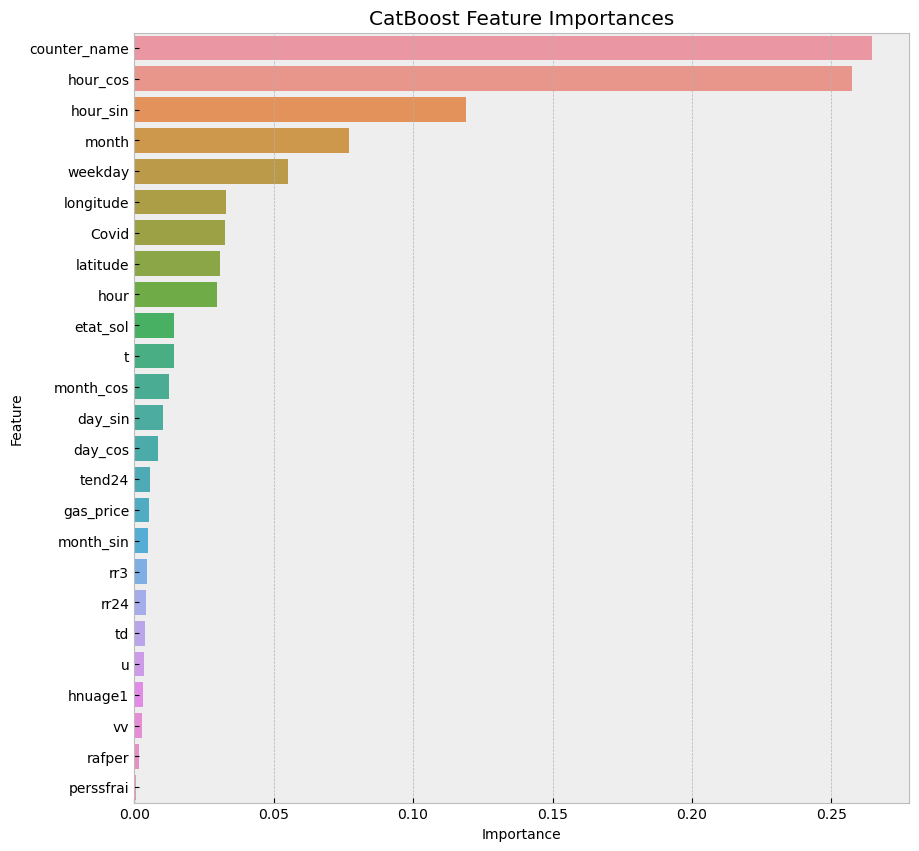

In [12]:
feature_names = full_encode(
    X_test
).columns.tolist()  # Assuming encode functions keep column names

# Combine feature names and importances
feature_importances = pd.DataFrame(
    {
        "Feature": feature_names,
        "Importance": np.abs(pipe.named_steps["regressor"].feature_importances_)
        / (np.sum(np.abs(pipe.named_steps["regressor"].feature_importances_))),
    }
)

# Sort by importance
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=feature_importances.iloc[:, :])
plt.title("CatBoost Feature Importances")
plt.show()

Feature importance on sample with shap:

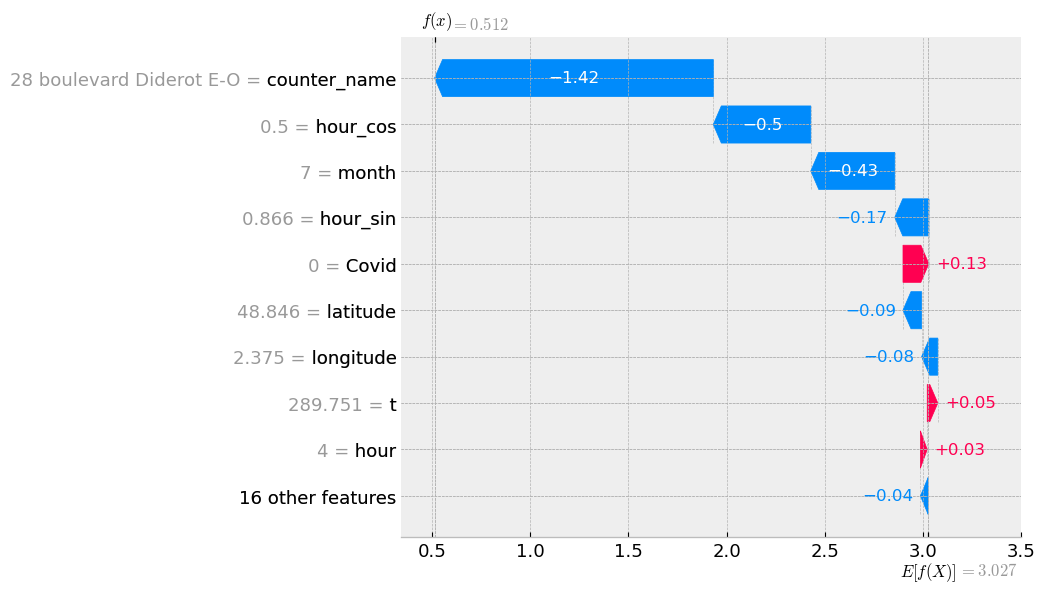

In [13]:
explainer = shap.Explainer(pipe.named_steps["regressor"])

shap_values = explainer(full_encode(X_test))

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

## Prediction visualization

In [14]:
rmse_per_counter = []

for c in X_test["counter_name"].unique():
    # Filter predictions and actual values based on the counter
    y_hat_counter = y_hat[X_test["counter_name"] == c]
    y_test_counter = y_test[X_test["counter_name"] == c]

    # Calculate RMSE for the current counter
    rmse = mean_squared_error(y_test_counter, y_hat_counter, squared=False)

    # Store results in the list
    rmse_per_counter.append({"Counter": c, "Test set RMSE": rmse})

# Convert the list to a DataFrame
rmse_per_counter = pd.DataFrame(rmse_per_counter)

# Sort the DataFrame based on the "Counter" column
rmse_per_counter = rmse_per_counter.sort_values(by="Test set RMSE", ascending=False)

# Print the sorted table
print(rmse_per_counter)

                                            Counter  Test set RMSE
52                        20 Avenue de Clichy NO-SE       1.756057
53                        20 Avenue de Clichy SE-NO       1.706432
50                           90 Rue De Sèvres NE-SO       1.010901
0                          28 boulevard Diderot E-O       0.898777
51                           90 Rue De Sèvres SO-NE       0.798060
35                     Face au 40 quai D'Issy SO-NE       0.699960
34                     Face au 40 quai D'Issy NE-SO       0.686528
24                          Pont de la Concorde S-N       0.658991
46                         Totem Cours la Reine E-O       0.604574
6                       Voie Georges Pompidou NE-SO       0.591365
47                         Totem Cours la Reine O-E       0.586681
16                         6 rue Julia Bartet SO-NE       0.585050
14                     Face au 70 quai de Bercy S-N       0.575936
25                           Pont des Invalides N-S       0.55

Plot predictions for counters with worst residuals

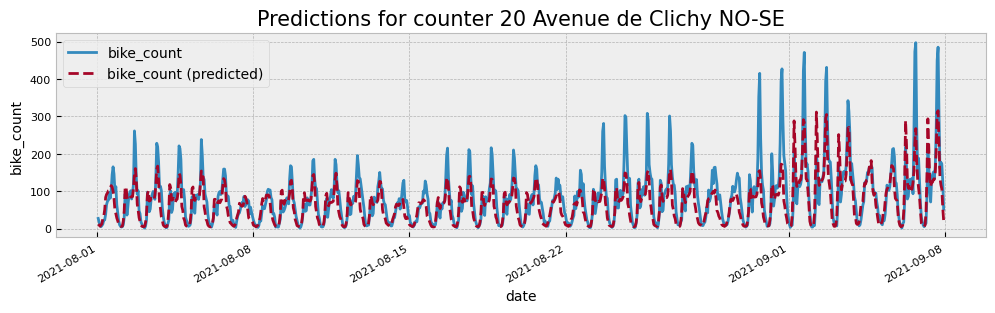

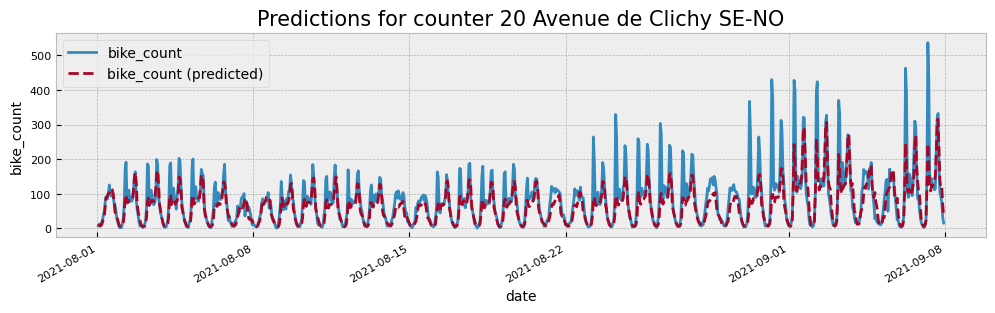

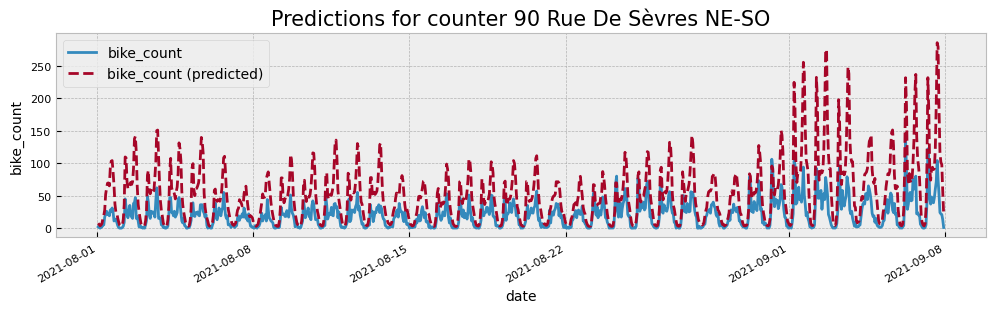

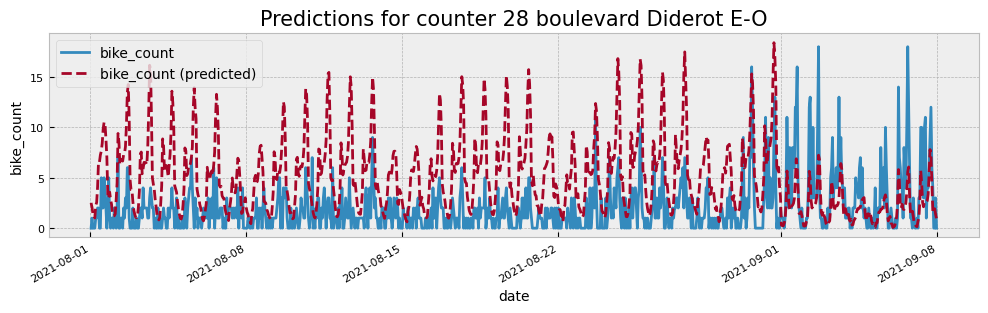

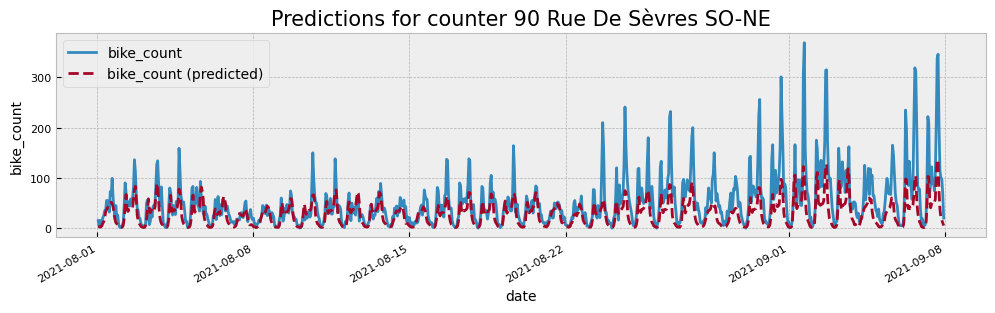

In [15]:
for c in rmse_per_counter["Counter"].iloc[:5]:
    mask = (
        (X_test["counter_name"] == c)
        & (X_test["date"] > pd.to_datetime("2021/08/01"))
        & (X_test["date"] < pd.to_datetime("2021/09/08"))
    )

    df_viz = X_test.loc[mask].copy()
    df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
    df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

    fig, ax = plt.subplots(figsize=(12, 3))

    df_viz.plot(x="date", y="bike_count", ax=ax)
    df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
    ax.set_title(f"Predictions for counter {c}", fontsize=15)
    ax.set_ylabel("bike_count")
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()